# This notebook finds the final MAPEs for all corn test set combinations

### CONTENTS

### 1 Imports
### 2 Define error functions
### 3 Load and evaluate individual daily forecasts
### 4 Evaluate daily combinations
### 5 Load and evaluate individual weekly forecasts
### 6 Evaluate weekly combinations
### 7 Evaluate combination with weather

# 1 Imports

In [2]:
import numpy as np
import pandas as pd

from scipy import stats

import random

import matplotlib.pyplot as plt
import matplotlib.dates

from google.colab import drive
import json

# 2 Define error functions

In [3]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns mean absolute percentage error
def mape(forecast, actual):
  return np.mean(np.abs(forecast - actual)/np.abs(actual))

In [4]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns root mean squared error
def rmse(forecast, valid):
    return (np.mean((forecast - valid)**2))**.5  # RMSE

# 3 Load and evaluate individual daily forecasts

In [5]:
# Get untampered validation set for error evaluation

# Import daily data
data_url = 'https://raw.githubusercontent.com/ptraver/data/main/corn_daily_V2.csv'
corn_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
corn_df.columns = ['value']

# take only 1974 - 2017
corn_df = corn_df['1974-01-01':'2017-12-31']

# corn_df needs to lose last value becuase during process of VMD, the last value is lost
corn_df = corn_df[:-1]

# get test set
from sklearn.model_selection import train_test_split
true_train, out_of_sample = train_test_split(corn_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)

In [6]:
# flatten the valid set for comparing with forecasts
true_test = true_test.values.flatten()

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# Load emd_arima
with open('/content/gdrive/My Drive/outputs/emd_ARIMA_daily_test.json') as fp:
  emd_arima = np.array(json.load(fp))

# Load vmd arima
with open('/content/gdrive/My Drive/outputs/vmd_ARIMA_daily_test.json') as fp:
  vmd_arima = np.array(json.load(fp))

# Load emd_RNN
emd_RNN = np.load('/content/gdrive/My Drive/outputs/emd_RNN_daily_test.npy')

# Load vmd_RNN
vmd_RNN = np.load('/content/gdrive/My Drive/outputs/vmd_RNN_daily_test.npy')

# Load true_RNN
true_RNN = np.load('/content/gdrive/My Drive/outputs/true_RNN_daily_test.npy')

In [9]:
# Check shapes
print(true_test.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(1109,)
(1109,)
(1109,)
(1109,)
(1109,)
(1109,)


In [10]:
# Check individual mape scores
print(mape(emd_arima, true_test))
print(mape(vmd_arima, true_test))
print(mape(emd_RNN, true_test))
print(mape(vmd_RNN, true_test))
print(mape(true_RNN, true_test))

0.006804921842848355
0.005429657140315615
0.006920211418649114
0.0062457352998604105
0.012715884800175398


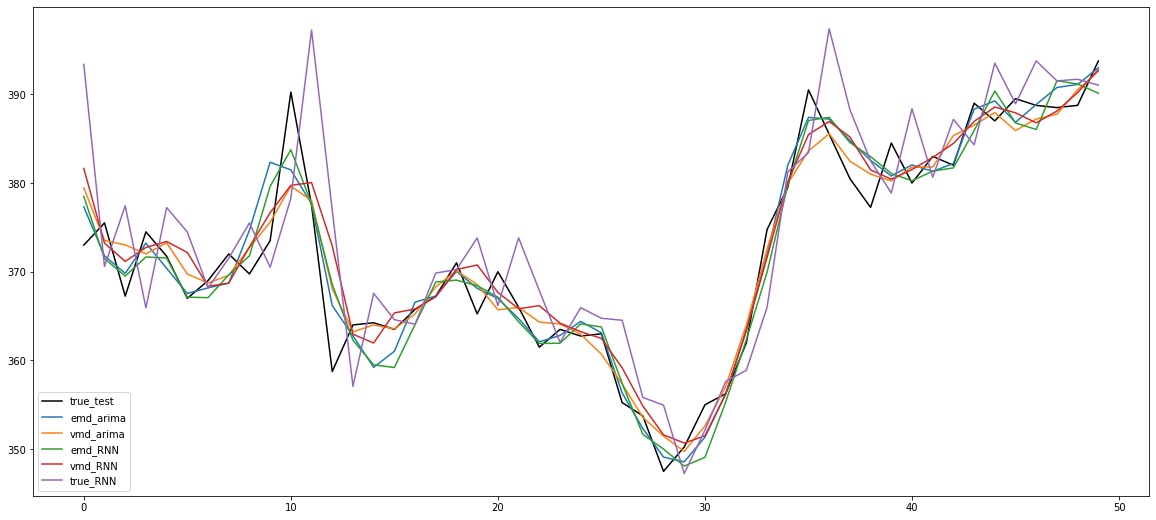

In [12]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_test[500:550], label='true_test', color='k')
plt.plot(emd_arima[500:550], label='emd_arima')
plt.plot(vmd_arima[500:550], label='vmd_arima')
plt.plot(emd_RNN[500:550], label='emd_RNN')
plt.plot(vmd_RNN[500:550], label='vmd_RNN')
plt.plot(true_RNN[500:550], label='true_RNN')
plt.legend()
plt.show()

In [14]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[490.96184294, 499.64399151, 491.08184814, 497.17431641,
        499.35568237],
       [484.26906295, 486.47105633, 485.08996582, 489.64779663,
        504.28048706],
       [477.70055349, 476.08952312, 478.48501587, 479.01629639,
        490.16360474],
       ...,
       [351.57600614, 347.71923565, 350.44070435, 349.48416138,
        349.2713623 ],
       [354.84458465, 349.18365879, 354.29534912, 349.79492188,
        349.64056396],
       [356.93160386, 349.61881972, 356.83496094, 350.56665039,
        352.21533203]])

# 4 Evaluate daily combinations

In [15]:
# 2-model

ABC_weights = [0.08030307, 0.91983624, 0, 0, 0]
EIDS_weights = [-0.004459413423738708, 1.0044594134237388, 0, 0, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.005434704373425744
EIDS MAPE:  0.005430475745687164


In [16]:
# 4-model

ABC_weights = [ 0.48354845, 0.60915729, -0.38029764, 0.28595114, 0]
EIDS_weights = [0.11210837861597125, 1.0923962781877739, -0.10964491498632828, -0.09485974181741635, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.005587567527721685
EIDS MAPE:  0.00541225437068461


In [18]:
# 5-model

ABC_weights = [ 0.22229898, 0.4933079, 0.05887676, 0.2585066, -0.03327698]
EIDS_weights = [0.1526935956748619, 1.2110242742509398, -0.14750315790715984, -0.05864908088127666, -0.1575656311373646]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.0055531791093304545
EIDS MAPE:  0.005207992533702057


# 5 Load and evaluate individual weekly forecasts

In [20]:
# Get untampered validation set for error evaluation

# Import daily data
data_url = 'https://raw.githubusercontent.com/ptraver/data/main/corn_weekly.csv'
corn_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
corn_df.columns = ['value']

# take only 1974 - 2017
corn_df = corn_df['1974-01-01':'2017-12-31']

# corn_df needs to lose last value becuase during process of VMD, the last value is lost
corn_df = corn_df[:-1]

# get validation set
from sklearn.model_selection import train_test_split
true_train, out_of_sample = train_test_split(corn_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)

In [21]:
# flatten the valid set for comparing with forecasts
true_test = true_test.values.flatten()

In [22]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
# Load emd_arima
with open('/content/gdrive/My Drive/outputs/emd_ARIMA_weekly_test.json') as fp:
  emd_arima = np.array(json.load(fp))

# Load vmd arima
with open('/content/gdrive/My Drive/outputs/vmd_ARIMA_weekly_test.json') as fp:
  vmd_arima = np.array(json.load(fp))

# Load emd_RNN
emd_RNN = np.load('/content/gdrive/My Drive/outputs/emd_RNN_weekly_test.npy')

# Load vmd_RNN
vmd_RNN = np.load('/content/gdrive/My Drive/outputs/vmd_RNN_weekly_test.npy')

# Load true_RNN
true_RNN = np.load('/content/gdrive/My Drive/outputs/true_RNN_weekly_test.npy')

In [24]:
# Check shapes
print(true_test.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(230,)
(230,)
(230,)
(230,)
(230,)
(230,)


In [25]:
# Check individual mape scores
print(mape(emd_arima, true_test))
print(mape(vmd_arima, true_test))
print(mape(emd_RNN, true_test))
print(mape(vmd_RNN, true_test))
print(mape(true_RNN, true_test))

0.015183618804024721
0.012555895612422168
0.01525704736560228
0.013100493422172607
0.0200725128702719


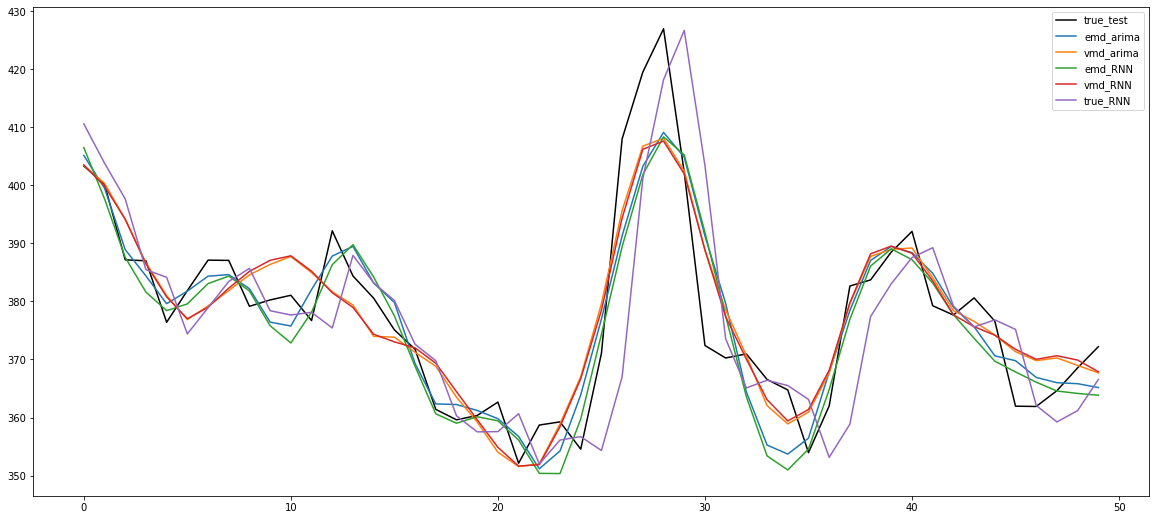

In [27]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_test[75:125], label='true_test', color='k')
plt.plot(emd_arima[75:125], label='emd_arima')
plt.plot(vmd_arima[75:125], label='vmd_arima')
plt.plot(emd_RNN[75:125], label='emd_RNN')
plt.plot(vmd_RNN[75:125], label='vmd_RNN')
plt.plot(true_RNN[75:125], label='true_RNN')
plt.legend()
plt.show()

In [28]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[564.79163403, 529.36587386, 563.47924805, 538.09222412,
        556.82312012],
       [522.302254  , 516.51335639, 518.72875977, 523.07531738,
        501.87460327],
       [476.62843083, 485.11763274, 480.45510864, 496.38485718,
        468.80413818],
       ...,
       [341.44576485, 341.36053662, 339.75805664, 341.19396973,
        341.58129883],
       [342.69178634, 339.55886259, 340.96417236, 340.22134399,
        338.90103149],
       [343.7290489 , 340.10818397, 342.1519165 , 340.05288696,
        338.51898193]])

# 6 Evaluate weekly combinations

In [30]:
# 2-model

ABC_weights = [0, 0.48263215, 0.51869816, 0, 0]
EIDS_weights = [0, 0.5355618984854706, 0.46443810151452924, 0, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.012630184797673232
EIDS MAPE:  0.012416054728405334


In [31]:
# 4-model

ABC_weights = [0.08728169, 0.59377955, 0.43502419, -0.11466327, 0]
EIDS_weights = [-0.12000787911199841, 1.3566419314888205, 0.5710596316107718, -0.8076936839875936, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.012656473343089185
EIDS MAPE:  0.012176167758271215


In [32]:
# 5-model

ABC_weights = [0.24850518, 0.25409307, 0.32541322, 0.21627039, -0.04335287]
EIDS_weights = [0.11604528800530896, 0.9344382154626634, 0.46827910222868097, -0.3993313043431633, -0.11943130135348955]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.012867851939088397
EIDS MAPE:  0.012665260546188606


# 7 Evaluate combination with weather

In [33]:
# Load weather_RNN
true_RNN = np.load('/content/gdrive/My Drive/outputs/true_RNN_weather_test.npy')

In [34]:
# Reshape sets because the first few prediction values are not in weather prediction
true_test = true_test[4:]
emd_arima = emd_arima[4:]
vmd_arima = vmd_arima[4:]
emd_RNN = emd_RNN[4:]
vmd_RNN = vmd_RNN[4:]

In [35]:
# Check shapes
print(true_test.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(226,)
(226,)
(226,)
(226,)
(226,)
(226,)


In [37]:
# Check individual mape scores
print(mape(emd_arima, true_test))
print(mape(vmd_arima, true_test))
print(mape(emd_RNN, true_test))
print(mape(vmd_RNN, true_test))
print(mape(true_RNN, true_test))

0.01440530493602525
0.012159498271091172
0.01450987732498823
0.01244677645618961
0.022783750147841925


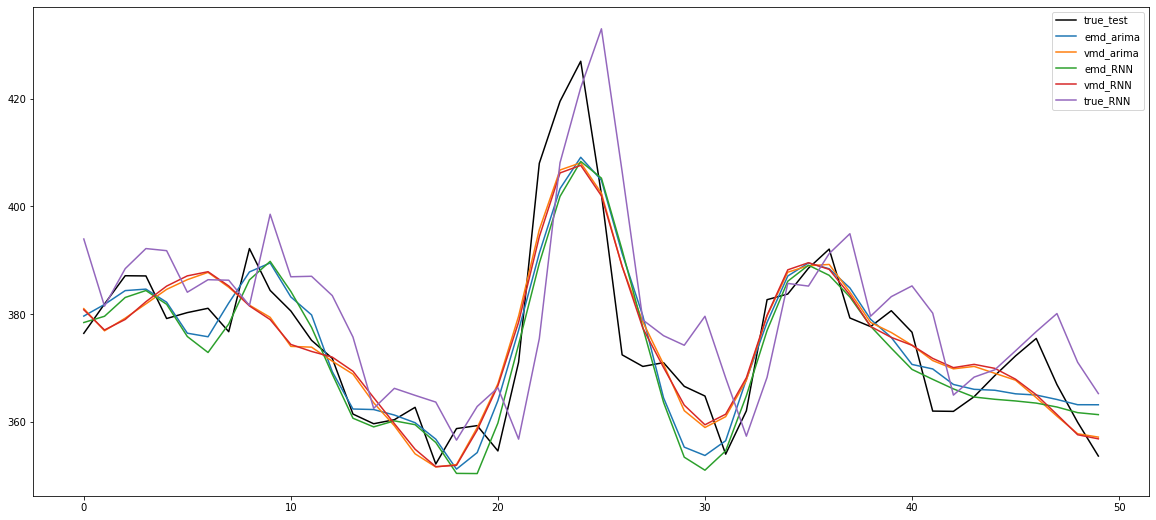

In [38]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_test[75:125], label='true_test', color='k')
plt.plot(emd_arima[75:125], label='emd_arima')
plt.plot(vmd_arima[75:125], label='vmd_arima')
plt.plot(emd_RNN[75:125], label='emd_RNN')
plt.plot(vmd_RNN[75:125], label='vmd_RNN')
plt.plot(true_RNN[75:125], label='true_RNN')
plt.legend()
plt.show()

In [39]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[427.03214402, 476.81630755, 427.5451355 , 480.94158936,
        472.50576782],
       [419.98792577, 483.73845269, 419.49078369, 487.7784729 ,
        497.81448364],
       [421.40035742, 486.86671591, 420.77862549, 490.66143799,
        506.32400513],
       ...,
       [341.44576485, 341.36053662, 339.75805664, 341.19396973,
        348.80484009],
       [342.69178634, 339.55886259, 340.96417236, 340.22134399,
        343.65231323],
       [343.7290489 , 340.10818397, 342.1519165 , 340.05288696,
        343.54907227]])

In [40]:
# 5-model weather combination

ABC_weights = [0.26756498, 0.284502, 0.33230094, 0.18057007, -0.06196596]
EIDS_weights = [-0.04663896135671462, 1.1523735605865495, 0.5751794899605669, -0.581173479696606, -0.09974060949379514]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.012448698201468222
EIDS MAPE:  0.012186648721087975
